In [ ]:
!python -m deeppavlov install /content/drive/MyDrive/files/levenshtein_corrector_ru.json

Traceback (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.10/dist-packages/deeppavlov/__main__.py", line 4, in <module>
    main()
  File "/usr/local/lib/python3.10/dist-packages/deeppavlov/deep.py", line 62, in main
    install_from_config(pipeline_config_path)
  File "/usr/local/lib/python3.10/dist-packages/deeppavlov/utils/pip_wrapper/pip_wrapper.py", line 56, in install_from_config
    requirements_files = get_config_requirements(config)
  File "/usr/local/lib/python3.10/dist-packages/deeppavlov/utils/pip_wrapper/pip_wrapper.py", line 43, in get_config_requirements
    config = parse_config(config)
  File "/usr/local/lib/python3.10/dist-packages/deeppavlov/core/commands/utils.py", line 121, in parse_config
    config = read_json(find_config(config))
  File "/usr/local/l

In [ ]:
pip install navec

In [ ]:
from navec import Navec

path = '/content/drive/MyDrive/files/navec_hudlit_v1_12B_500K_300d_100q.tar'
navec = Navec.load(path)

In [ ]:
pip install slovnet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.7/46.7 kB 2.3 MB/s eta 0:00:00


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from slovnet.model.emb import NavecEmbedding
import torch
import re
import pymorphy2

In [ ]:
import sys

from deeppavlov import build_model, configs

CONFIG_PATH = configs.spelling_correction.levenshtein_corrector_ru
# CONFIG_PATH.max_distance = 4

model = build_model(CONFIG_PATH, download=True)
for line in sys.stdin:
    print(model([line])[0], flush=True)

In [ ]:
morph = pymorphy2.MorphAnalyzer()
TO_DELETE = {'CONJ', 'PREP', 'PRCL', 'INTJ', 'NUMR', 'NPRO'}



def normalize(string: str) -> list[str]:
  # print("llllllllllll")
  lower_string = string.lower()
  lower_string = lower_string.replace('\t', ' ').replace('\n', ' ')
  lower_string = lower_string.replace("зам. ", "заместитель ")\
    .replace("нач. ", "начальник ")\
        .replace("рук. ", "руководитель ")\
            .replace("ген. ", "генеральный ")\
                .replace("ст. ", "старший ")
  # lower_string = lower_string.replace("–", "-")
  # lower_string = lower_string.replace(" - ", "-")
  # remove numbers
  no_number_string = re.sub(r'\d+','',lower_string)

  # remove all punctuation except words and space
  no_punc_string = re.sub(r'[^\w\s]',' ', no_number_string)
  no_wspace_string = no_punc_string.strip()
  lst_string = no_wspace_string.split()
  if lst_string == []:
    return []
  pav_lst = model(lst_string)
  # for ind in range(len(lst_string), 256):
  #   try:
  #     output = model(lst_string)
  #     for sub in output.split():
  #       pav_lst.append(sub)
  #     # if " " in output:
  #     #   print(word, output)
  #   except IndexError:
  #     print(word)
  # print(pav_lst)

  normalized_lst = []
  for i in pav_lst:
    word = morph.parse(i)[0]
    if word.tag.POS not in TO_DELETE:
      word = word.normal_form
      for sub in word.split():
        normalized_lst.append(sub.replace("ё", "е"))

  return normalized_lst


In [ ]:
normalized1 = normalize('''Ветеринарный врач
1. Осмотр животных и диагностирование их болезней и повреждений.
2. Исследование причин возникновения, процессов протекания болезней животных, разборку методов их лечения и профилактики.
3. Терапевтическое и хирургическое лечение животных.
4. Применение лекарственных средств при лечении животных, высокоэффективные ветеринарные препараты и методы ветеринарного воздействия.
5. Контроль выполнения зоогигиенических и ветеринарных правил при содержании, кормлении животных и уходе за ними на стационарном лечении.
6. Проведение ветеринарно-санитарной экспертизы скота 7. Осуществление руководства подчиненными ему работниками ветеринарного учреждения.''')
vec1 = [navec[word] for word in normalized1 if word in navec]
sum_vec1 = sum(vec1)

In [ ]:
normalized2 = normalize('''Ветеринарный врач
Выполнение ветеринарного законодательства. Контроль и своевременное выявление заболеваний. Профилактика и лечение.''')
vec2 = [navec[word] for word in normalized2 if word in navec]
sum_vec2 = sum(vec2)

In [ ]:
normalized3 = normalize('''Агроном
знание и умение выращивания посадочного материала, составление и видение технологического процесса выращивания продукции на протяжении года: обрезка, организация и контроль системы полива, мониторинг болезней и вредителей, подбор и внесение ядохимикатов.''')
vec3 = [navec[word] for word in normalized3 if word in navec]
sum_vec3 = sum(vec3)

In [ ]:
from sklearn.metrics.pairwise import cosine_distances


cosine_distances([sum_vec2], [sum_vec3])

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/files/jobs.csv')
df

FileNotFoundError: ignored

In [ ]:
df["name_err"] = df["name"].apply(lambda x: " ".join([word for word in normalize(x) if word not in navec]))

In [ ]:
df

In [ ]:
arr = list(df["name_err"].unique())
arr.remove("")
full = []
for e in arr:
  if " " in e:
    for j in e.split():
      full.append(j)
  else:
    full.append(e)
full

['асфальтоукладчик',
 'мясопереработка',
 'переработчик',
 'обвальщик',
 'обвалочный',
 'обвальщик',
 'системотехника',
 'автотранспортный',
 'сельхозтехника',
 'электрослесарь',
 'рыбовод',
 'слесарить',
 'электромонтажник',
 'бетонщик',
 'малотоннажный',
 'доращивание',
 'откормочный',
 'комбикормовый',
 'обвалочный',
 'семеновод',
 'пиццеола',
 'автохозяйство',
 'комплектовщик',
 'deere',
 'крановый',
 'медиаканал',
 'опорос',
 'опорос',
 'насосный',
 'спецтехник',
 'противоэпизоотический',
 'эпизоотический',
 'животноводческий',
 'эпизоотолог',
 'красногоровский',
 'свинотоварный',
 'зооветспециалист',
 'инкубаторий',
 'товароучет',
 'автозапчасть',
 'поломоечный',
 'асутп',
 'картцентр',
 'автослужба',
 'пэвм',
 'мыловарение',
 'фуражир',
 'сбеж',
 'формовка',
 'паразитологический',
 'сельхозпроизводство',
 'семеновод',
 'агрохимик',
 'рисовод',
 'эксковаторшик',
 'сельхозтехника',
 'варщик',
 'агроинженер',
 'обязаностимя',
 'слесарить',
 'механосборочный',
 'стропальщик',
 'паке

In [ ]:
len(full)

378

In [ ]:
df["name_to_fix"] = df["name"].apply(lambda x: " ".join(normalize(x)))

In [ ]:
df["name_to_fix"].nunique()

2096

In [ ]:
arr1 = list(df["name_norm"])
arr1.remove("")
full1 = []
for e in arr1:
  if " " in e:
    for j in e.split():
      full1.append(j)
  else:
    full1.append(e)
len(set(full1))

1179

In [ ]:
df["bag_of_words"] = df["name"].apply(lambda x: sum([navec[word] for word in normalize(x) if word in navec]))

In [ ]:
df.iloc[41]

Unnamed: 0                                                     41
id                                                             11
start_date                                             2004-11-01
num_month                                                      33
name                                                Электромонтер
description     работа в области электрики и электротехники, м...
sex                                                       Мужчина
birthday                                               1967-03-25
edu_level                                                       3
num_lang                                                        2
skills                                                        NaN
filename        data/resumes/73be5dfa000209cc5a0039ed1f6c42305...
name_err                                            электромонтёр
name_norm                                                        
name_to_fix                                         электромонтёр
bag_of_wor

In [ ]:
df["bag_of_words"] = df["bag_of_words"].apply(lambda x: navec["<pad>"] if isinstance(x, int) else x)

In [ ]:
df["bag_of_words"] = df["bag_of_words"].apply(lambda x: navec["<pad>"] if isinstance(x, str) else x)


In [ ]:
data = np.stack(np.array(df["bag_of_words"]), axis=0)
nonzero_data = [e for e in data if not np.array_equal(e, navec["<pad>"])]

In [ ]:
distances = cosine_distances(nonzero_data, nonzero_data)

(array([1.26355e+05, 1.19600e+03, 1.01600e+03, 2.96400e+03, 1.04160e+04,
        5.26760e+04, 2.65060e+04, 2.96600e+04, 1.21080e+04, 1.98160e+04,
        1.34380e+04, 3.18280e+04, 4.38180e+04, 4.15620e+04, 5.11420e+04,
        3.17460e+04, 3.52640e+04, 1.95000e+04, 2.61500e+04, 5.87820e+04,
        4.04340e+04, 4.52480e+04, 6.93400e+04, 4.91320e+04, 6.05560e+04,
        9.92840e+04, 7.59180e+04, 8.48920e+04, 1.03152e+05, 1.37764e+05,
        1.18984e+05, 1.58190e+05, 1.74692e+05, 2.12154e+05, 2.08802e+05,
        2.81708e+05, 2.46488e+05, 3.39750e+05, 3.86424e+05, 3.97370e+05,
        3.88496e+05, 3.65400e+05, 4.45778e+05, 4.42256e+05, 4.52566e+05,
        5.49602e+05, 5.28788e+05, 5.21798e+05, 5.23758e+05, 5.33785e+05,
        5.85691e+05, 5.89014e+05, 5.86994e+05, 5.82542e+05, 5.58362e+05,
        5.84126e+05, 5.61430e+05, 5.24798e+05, 4.93528e+05, 4.71642e+05,
        4.74132e+05, 4.46672e+05, 3.94791e+05, 3.35297e+05, 3.07132e+05,
        2.74112e+05, 2.43428e+05, 2.22144e+05, 1.93

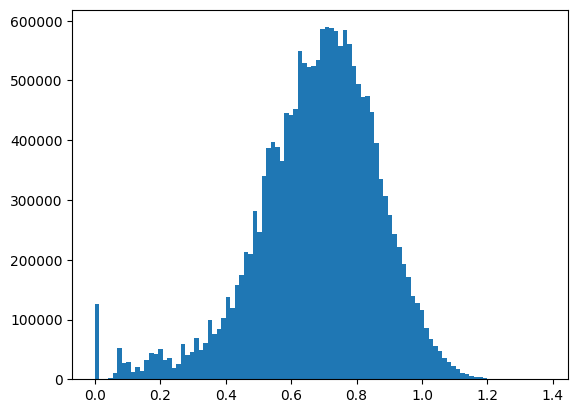

In [ ]:
plt.hist(distances.flatten(), bins=100)

In [ ]:
nonzero_data = [e for e in data if not np.array_equal(e, navec["<pad>"])]

In [ ]:
nonzero_distances

[array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 